# Steam Games Analysis
## Introduction
Let's imagine that we are data analytics in Game Development company (like Valve/Shiro Games/EA/etc) that focuses on PC games and would like to publish a game within Steam Platform. The lead game designer has an interesting idea to develop a game in Turn-Based genre (like Civilization/Hearthstone/Divinity). Our small company want to figure out the profitability and popularity of this genre because it seems there are few projects in this field for a while. Moreover, if this genre is not considerable to develop in, what similar genres will be the best to develop in? Hence, our goals are:
> 1. Is turn-based game is considerable to develop? 
2. What are the best other similar genres our game developers should consider as well? 
3. What games our product will compete with?

But what does 'considerable' mean ? A considerable to develop game should be profitable for a company. So, we will figure out the average profit for this kind of genre. 

What about 'the best similar genres'? Since turn-based games are mostly strategies, we will check other related genre in comparison to the turn-base genre.  

To reach our goal, we will use [Nik Davis scraped data from Steam and SteamAPIs](https://www.kaggle.com/nikdavis/steam-store-games) due to the fact that it's pretty up-to-date data set, it has all needed parameters and it's already clean (anyway, we will double-check it). 
## Overview

In [1]:
#importing libraries to work with
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import datetime

In [2]:
# importing data set. Cast release_date column as date type.
df_games = pd.read_csv('steam.csv', parse_dates = ['release_date'])
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   appid             27075 non-null  int64         
 1   name              27075 non-null  object        
 2   release_date      27075 non-null  datetime64[ns]
 3   english           27075 non-null  int64         
 4   developer         27075 non-null  object        
 5   publisher         27075 non-null  object        
 6   platforms         27075 non-null  object        
 7   required_age      27075 non-null  int64         
 8   categories        27075 non-null  object        
 9   genres            27075 non-null  object        
 10  steamspy_tags     27075 non-null  object        
 11  achievements      27075 non-null  int64         
 12  positive_ratings  27075 non-null  int64         
 13  negative_ratings  27075 non-null  int64         
 14  average_playtime  2707

In [3]:
# first 5 rows of data set
df_games.head(5)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


What columns do we have here? According to above-showed and README, the columns are:
- sort — Unique identifier for each title
- name — Title of app (game)
- release_date — Release date in format YYYY-MM-DD
- english — Language support: 1 if is in English
- developer — Name (or names) of developer(s). Semicolon delimited if multiple
- publisher — Name (or names) of publisher(s). Semicolon delimited if multiple
- platforms — Semicolon delimited list of supported platforms. At most includes: windows;mac;linux
- required_age — Minimum required age according to PEGI UK standards. Many with 0 are unrated or unsupplied.
- categories — Semicolon delimited list of game categories, e.g. single-player;multi-player
- genres — Semicolon delimited list of game genres, e.g. action;adventure
- steamspy_tags — Semicolon delimited list of top steamspy game tags, similar to genres but community voted, e.g. action;adventure
- achievements — Number of in-games achievements, if any
- positive_ratings — Number of positive ratings, from SteamSpy
- negative_ratings — Number of negative ratings, from SteamSpy
- average_playtime — Average user playtime, from SteamSpy
- median_playtime — Median user playtime, from SteamSpy
- owners — Estimated number of owners. Contains lower and upper bound (like 20000-50000). May wish to take mid-point or lower bound. Included both to give options.
- price — Current full price of title in GBP, (pounds sterling)

## Cleaning Data
### Checking NaN values

In [4]:
# There are no NAN values
print(df_games.isna().sum(), '\n')

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64 



### Transforming data
To make data management easier, we will transform genre and tags columns into a list of values.

In [5]:
# transforming into lists of genres
df_games['genres'] = df_games['genres'].str.lower().str.split(';')
df_games['steamspy_tags'] = df_games['steamspy_tags'].str.lower().str.split(';')

In [6]:
# making a frequency table for the genre column
fq_genre = {}
def make_fq_dict(row, a_dict):
    for i in row:
        if i in a_dict:
            a_dict[i] += 1
        else:
            a_dict[i] = 1
df_games['genres'].apply(make_fq_dict, a_dict = fq_genre)
genres = pd.Series(fq_genre)

In [7]:
genres.sort_index()

accounting                   6
action                   11903
adventure                10032
animation & modeling        79
audio production            29
casual                   10210
design & illustration       87
documentary                  1
early access              2954
education                   51
free to play              1704
game development            17
gore                       537
indie                    19421
massively multiplayer      723
nudity                     266
photo editing               12
racing                    1024
rpg                       4311
sexual content             245
simulation                5194
software training           31
sports                    1322
strategy                  5247
tutorial                     1
utilities                  146
video production            38
violent                    843
web publishing              28
dtype: int64

Since the `genre` column contains only given by developers/steam genre, it does not display the actual landscape and there are no Turn-based genre (only strategy which is not the same). Luckily, there is the `steamspy_tags` column which looks similar but community voted which makes it more representative. 

In [8]:
fq_tags = {}
df_games['steamspy_tags'].apply(make_fq_dict, a_dict = fq_tags)
tags = pd.Series(fq_tags)
tbg_list = tags[tags.index.str.contains('turn')].index
print(tbg_list)

Index(['turn-based strategy', 'turn-based', 'turn-based tactics',
       'turn-based combat'],
      dtype='object')


Due to the fact that all these tags represent same genre, we will replace any appears of "turn-based..." to "turn-based". 

In [9]:
def adj_genres(row, genre, genre_to_change):
    for n, i in enumerate(row):
        if i in genre_to_change:
            row[n] = genre
    # excluding repeats
    return list(set(row))


df_games['steamspy_tags'] = df_games['steamspy_tags'].apply(adj_genres, genre = 'turn-based', genre_to_change = tbg_list)
tbg_mask = df_games['steamspy_tags'].apply(lambda x: 'turn-based' in x)

#checking the tranformation
df_games[tbg_mask]['steamspy_tags']

36            [turn-based, fantasy, strategy]
37            [turn-based, classic, strategy]
86                [turn-based, strategy, rpg]
115                    [turn-based, strategy]
116                    [turn-based, strategy]
                         ...                 
25058        [turn-based, board game, casual]
25106    [turn-based, world war ii, strategy]
25253           [turn-based, indie, strategy]
25686           [turn-based, indie, strategy]
26956             [turn-based, rpgmaker, rpg]
Name: steamspy_tags, Length: 297, dtype: object

Here we go! These game tags we are interested in. But are this genre popular at all?
## Analyzing Data
### Most used tags

In [10]:
tbg_fraction = tags[tbg_list].sum()/tags.sum()
print('Turn-based genre constitute {:.2%} of all tags. While the top popular genres shown below:'.format(tbg_fraction))
top10_tags = (tags.sort_values(ascending=False).head(15)/tags.sum() * 100).round(2)
print(top10_tags)

Turn-based genre constitute 0.41% of all tags. While the top popular genres shown below:
indie           20.81
action          13.23
casual          10.52
adventure        9.96
strategy         5.35
simulation       4.21
early access     3.80
rpg              3.57
free to play     2.13
puzzle           1.43
vr               1.23
sports           1.00
racing           0.98
platformer       0.83
nudity           0.73
dtype: float64


Small game dev companies are indeed on a fire (indie is independent) and we have a good chances to blossom. Back to the goal and bearing in mind, that `indie`, `early access` , `free to play` and some other tags are not genres, turn-based games look not so bad as it initially seems. 

Now we can see the frequency of tags usage. But are these games financially successful ?(although, we are working in a small company for the mutual idea, we need to pay salaries). Game profit we will count as multiplying mid-point of owners amount and the price of the game. 
### Most profitable games 

In [11]:
# since game owners column is a range, we need to transform it into mid point.
def find_midpoint(row):
    a_list = row.split('-')
    midpoint = (float(a_list[0]) + float(a_list[1]))/2
    return int(midpoint)


df_games['avg_owners'] = df_games['owners'].apply(find_midpoint)
df_games['profit'] = df_games['avg_owners'] * df_games['price']

In [12]:
# Let's make eye-catching plots
%matplotlib inline
plt.style.use('fivethirtyeight')

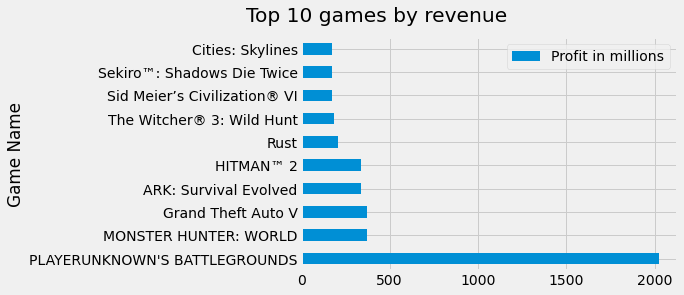

In [13]:
top10_profit = df_games.sort_values('profit', ascending=False).head(10)
top10_profit.profit = top10_profit.profit/1000000
top10_profit.plot.barh(x = 'name', y = 'profit', label = 'Profit in millions')
plt.title('Top 10 games by revenue', y = 1.04, x = 0.2)
plt.ylabel('Game Name')
plt.show()

It's (already) pretty obvious what the most profitable games are. You can check similar "Top sellers" tab in the main menu of Steam. 

![Image](https://ggtriple.files.wordpress.com/2015/06/steam-top-sellers-hatred-lego-worlds.jpg)

But we are interested in Turn-Based games. Do they have enough audience to be developed? To figure out this, we need to understand the average profit for all games (excluding such outliers as Playerunknown's battleground).

In [14]:
# transforming profit into millions 
df_games['profit'] /= 1000000
df_games.rename({'profit':'profit_mil'}, axis = 1, inplace=True)

In [15]:
df_games['profit_mil'].describe()

count    27075.000000
mean         1.139978
std         14.695720
min          0.000000
25%          0.019900
50%          0.055900
75%          0.149900
max       2024.250000
Name: profit_mil, dtype: float64

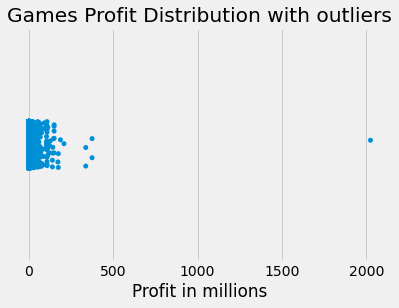

In [16]:
sns.stripplot(x = 'profit_mil', data = df_games, jitter = True)
plt.title('Games Profit Distribution with outliers')
plt.xlabel('Profit in millions')
plt.show()

What do we observe here? This distribution is right-skewed which exlplained by super profitable games. Since our company is down to earth, we would like to exclude them as well as free to play games (we are interesting in publishing a non-free game).

In [17]:
# upper bond is the 3rd quartile + 1.5 * standart deviation
upper_bond = df_games['profit_mil'].quantile(0.75) + 1.5 * df_games['profit_mil'].std()

#creating an interval of non-outliers
outliers_interval = pd.Interval(0, upper_bond, 'right')

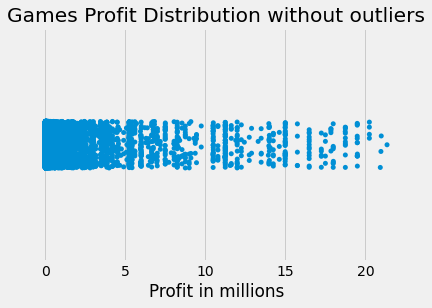

In [18]:
# creating a mask to exclude outliers
exclude_outliers_mask = df_games['profit_mil'].apply(lambda x: x in outliers_interval)
games_modif = df_games[exclude_outliers_mask].copy()

#Creating a strip plot
sns.stripplot(x = 'profit_mil', data = games_modif, jitter = True)
plt.xlabel('Profit in millions')
plt.title('Games Profit Distribution without outliers')
plt.show()

In [19]:
# double-check descriptive values
games_modif['profit_mil'].describe()

count    24216.000000
mean         0.490818
std          1.756142
min          0.007200
25%          0.028900
50%          0.061900
75%          0.154900
max         21.346500
Name: profit_mil, dtype: float64

### Creating genre table

Now, when we modified our game data set to appropriate view, we can move on to turn-based genres. Next step is better to explain - we are creating a table of genres which includes:

    - Summary of all games revenue in the genre
    - Usage frequency of every genre
    - Amount of game owners in the genre

In [20]:
genre_table = {}
def get_genres_table(row):
    for genre in row['steamspy_tags']:
        if genre in genre_table:
            genre_table[genre][0] += row['profit_mil']
            genre_table[genre][1] += 1
            genre_table[genre][2] += row['avg_owners']
        else:
            genre_table[genre] = []
            genre_table[genre].append(row['profit_mil'])
            genre_table[genre].append(1)
            genre_table[genre].append(row['avg_owners'])
games_modif.apply(get_genres_table, axis = 1);

In [21]:
genres = pd.DataFrame.from_dict(genre_table, orient = 'index', columns = ['profit_mil', 'frequency', 'game_genre_owners'])
genres.reset_index()

,index,profit_mil,frequency,game_genre_owners
0,multiplayer,702.43615,222,67385000
1,indie,2801.48955,15217,548290000
2,fighting,247.92885,101,16915000
3,action,3604.14370,9547,483195000
4,world war ii,162.95085,112,14465000
...,...,...,...,...
330,blood,0.01690,1,10000
331,nsfw,0.07190,1,10000
332,free to play,0.13965,1,35000
333,stylized,0.07190,1,10000


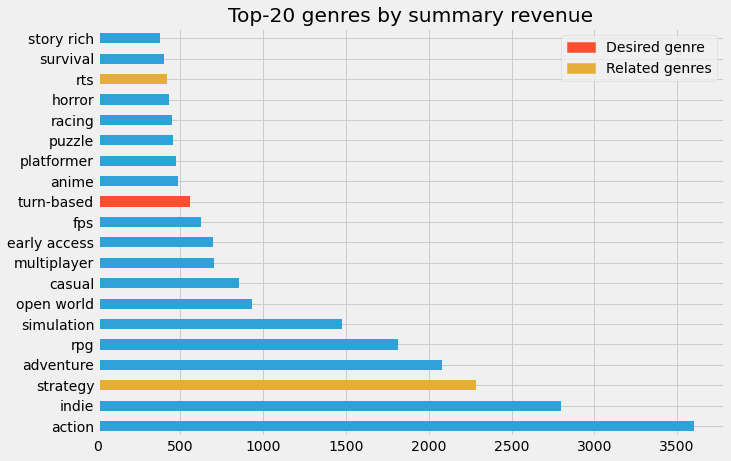

In [22]:
# creating patches for legend
red_patch = mpatches.Patch(color = '#fc4f30', label = 'Desired genre')
orange_patch = mpatches.Patch(color = '#e5ae38', label = 'Related genres')

#colors
blue_color = '#30a2da'
red_color = '#fc4f30'
orange_color = '#e5ae38'
colors = [blue_color]*20
colors[11] = red_color
for i in [2, -3]:
    colors[i] = orange_color
    
#adjustment of plot size
plt.figure(figsize = (10, 7))

#plotting
genres['profit_mil'].sort_values(ascending = False).head(20).plot.barh(color = colors, title = 'Top-20 genres by summary revenue')
#adding legend
plt.legend(handles=[red_patch, orange_patch])

plt.show()

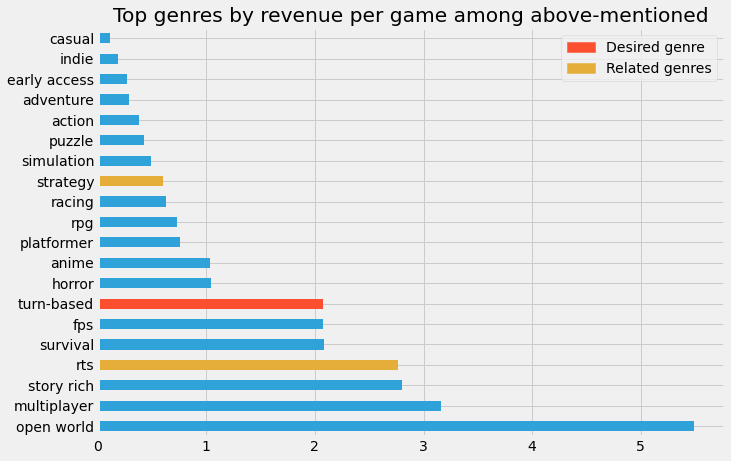

In [23]:
top20_genres = genres.loc[genres['profit_mil'].sort_values(ascending = False).head(20).index.format()]
top20_genres['avg_revenue_per_game'] = top20_genres['profit_mil']/top20_genres['frequency']

colors = [blue_color] * 20
for i in [3, -8]:
    colors[i] = orange_color
colors[6] = red_color
plt.figure(figsize = (10,7))
top20_genres.sort_values('avg_revenue_per_game', ascending=False)['avg_revenue_per_game'].plot.barh(color = colors, title = 'Top genres by revenue per game among above-mentioned')
plt.legend(handles=[red_patch, orange_patch])
plt.show()

And this is the answer to the first and second questions:
> 1. Is turn-based game is considerable to develop?
2. What are the best other similar genres our game developers should consider as well? 

YES! For sure, this genre is in demand. Moreover, games in this genre happened to have decent revenue in comparison with other popular genres. What about related genres: RTS (real-time strategy) is a good choice as well since it has equal potential to successed. 

## Comparison of genres

Taking into account that now we have 2 genres to select from, we will find all potential rivals in these fields and figure out which is preferable to have a niche in. To choose one, we can compare:
- the amount of games according to release dates - density, 
- average ratings, 
- and playtime value.

Let's start with adding the column of rating (positive - negative), replacing some similar to rts tags and then picking out games within selected genres into different table:

In [24]:
# To avoid doing it twice
games_modif['rating'] = games_modif['positive_ratings'] - games_modif['negative_ratings']

# I have found that there are some games which have similar genre tag. We need to replace them with 'rts'
rts_list = genres[genres.index.str.contains('real[\W]?time')].index.format()
print('Similar tags to RTS are: {}'.format(rts_list))
games_modif['steamspy_tags'] = games_modif['steamspy_tags'].apply(adj_genres, genre = 'rts', genre_to_change = rts_list)
rts_mask = games_modif['steamspy_tags'].apply(lambda x: 'rts' in x)

#checking the tranformation
games_modif[rts_mask]['steamspy_tags']

Similar tags to RTS are: ['real-time with pause', 'real-time', 'real time tactics']


30              [rts, indie, strategy]
33              [rts, indie, strategy]
42             [sci-fi, rts, strategy]
69             [action, rts, strategy]
85       [world war ii, rts, strategy]
                     ...              
25293    [city builder, rts, strategy]
25482                  [rts, strategy]
25984           [rts, indie, strategy]
26060           [rts, indie, strategy]
26108    [early access, rts, strategy]
Name: steamspy_tags, Length: 158, dtype: object

In [25]:
# Picking out genres into different table
needed_columns = ['name', 'release_date', 'average_playtime', 'median_playtime', 'profit_mil', 'rating', 'steamspy_tags']

# Creating 2 separate tables
rts_table = games_modif[rts_mask][needed_columns].copy()
tb_table = games_modif[games_modif['steamspy_tags'].apply(lambda x: 'turn-based' in x)][needed_columns].copy()

In [26]:
# Adding a column with main genre 
rts_table['target_genre'] = 'rts'
tb_table['target_genre'] = 'turn-based'
final_table  = pd.concat([rts_table, tb_table], ignore_index=True)

# Adding year as additional column
final_table['Release Year'] = final_table['release_date'].dt.year

### Average Playtime

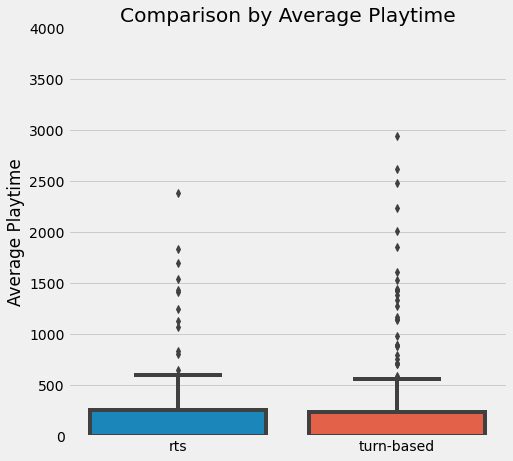

In [27]:
plt.figure(figsize = (7, 7))
sns.boxplot(x = 'target_genre', y = 'average_playtime', data = final_table)
plt.ylim(0, 4000)
plt.xlabel('')
plt.ylabel('Average Playtime')
plt.title('Comparison by Average Playtime')
plt.show()

As shown above, there is no clear difference in average playtime of the selected genres. What about dencity of released games for last years?
### Density of released games

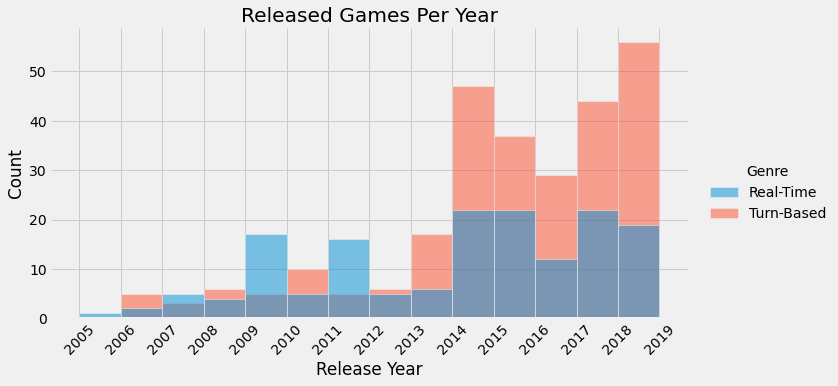

In [28]:
g = sns.displot(data = final_table, x = 'Release Year', hue = 'target_genre', aspect = 2)
g.legend.set_title("Genre")
for t, l in zip(g._legend.texts,("Real-Time", "Turn-Based")):
    t.set_text(l)
    
plt.title('Released Games Per Year')
plt.xticks(range(2005, 2020), rotation = 45)
plt.show()

It turned out that there are much more Turn-based games for last few years. Although, Turn-Based genre is still attractive to develop a game in, RTS genre has an empty niche which our company is available to occupy. What about average rating of these genres?

### Rating

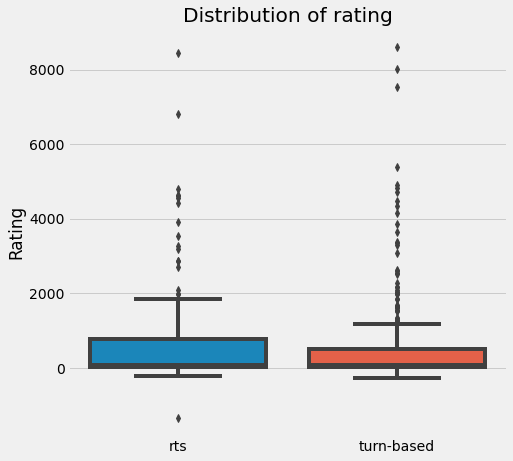

In [29]:
plt.figure(figsize = (7, 7))
sns.boxplot(data = final_table, x = 'target_genre', y = 'rating')
plt.title('Distribution of rating')
plt.xlabel('')
plt.ylabel('Rating')
plt.show()

Since there were less RTS games than turn-based for last few years, their rating is slightly better.  

In [30]:
comp_date = datetime.datetime(2018, 1, 1)
best5 = final_table[final_table['release_date'] > comp_date].groupby('target_genre')['profit_mil'].nlargest(5)

### Competitors

In [31]:
print('And there is top 5 games by revenue in each selected genre for last year:')
final_table.iloc[best5.index.get_level_values(1).astype(int).format()]

And there is top 5 games by revenue in each selected genre for last year:


,name,release_date,average_playtime,median_playtime,profit_mil,rating,steamspy_tags,target_genre,Release Year
143,Total War Saga: THRONES OF BRITANNIA,2018-05-02,279,399,4.49850,807,"[historical, rts, strategy]",rts,2018
141,Forged Battalion,2018-08-14,17,17,2.32350,228,"[rts, simulation, strategy]",rts,2018
135,Ancestors Legacy,2018-05-22,519,700,2.08425,1288,"[medieval, rts, strategy]",rts,2018
144,Driftland: The Magic Revival,2019-04-18,0,0,0.83265,325,"[simulation, rts, strategy]",rts,2019
149,Protolife,2018-06-15,0,0,0.32515,122,"[tower defense, rts, strategy]",rts,2018
399,DRAGON QUEST® XI: Echoes of an Elusive Age™ - ...,2018-09-04,2622,2622,5.99850,3382,"[turn-based, jrpg, rpg]",turn-based,2018
258,Pit People®,2018-03-02,327,388,5.42150,4716,"[funny, turn-based, strategy]",turn-based,2018
346,For The King,2018-04-19,1536,2022,5.42150,3870,"[turn-based, adventure, rpg]",turn-based,2018
401,Mutant Year Zero: Road to Eden,2018-12-04,301,398,4.49850,4352,"[turn-based, strategy, rpg]",turn-based,2018
364,Into the Breach,2018-02-27,1277,1738,3.98650,4819,"[turn-based, pixel graphics, strategy]",turn-based,2018


## Conclusion
As for me, if I were lead game-designer, I would opt for RTS genre because:
1. It has unoccupied niche
2. Noticable difference in revenue
3. Ratings are slightly better


But the final solution will be made by our company's game-designers they so they can use their domain knowledge to take the best decision.